In [3]:
%matplotlib inline
import csv
import json
import time
import sys
from concurrent.futures import ThreadPoolExecutor

import requests
import mwapi
import mwtypes
import pandas
import seaborn

In [4]:
session = mwapi.Session("https://en.wikipedia.org", user_agent="ahalfaker@wikimedia.org -- IWSC demo")

In [5]:
WEIGHTS = {'Stub': 1, 'Start': 2, 'C': 3, 'B': 4, 'GA': 5, 'FA': 6}
def score2sum(score_doc):
    if score_doc is None:
        return None
    weighted_sum = 0
    for cl, proba in score_doc['probability'].items():
        weighted_sum += WEIGHTS[cl] * proba
    return weighted_sum

In [8]:
def fetch_wp10_score(rev_id):
    response = requests.get('https://ores.wikimedia.org/v3/scores/enwiki/{0}/wp10'.format(rev_id))
    try:
        return response.json()['enwiki']['scores'][str(rev_id)]['wp10']['score']
    except:
        return None


def fetch_wp10_scores(rev_ids):
    executor = ThreadPoolExecutor(max_workers=8)
    return executor.map(fetch_wp10_score, rev_ids)

def fetch_historical_scores(page_name):
    historical_scores = []
    for response_doc in session.get(action='query', prop='revisions', titles=page_name, 
                                    rvprop=['ids', 'timestamp'], rvlimit=100, rvdir="newer", 
                                    formatversion=2, continuation=True):
        rev_docs = response_doc['query']['pages'][0]['revisions']
        rev_ids = [d['revid'] for d in rev_docs]
        for rev_doc, score_doc in zip(rev_docs, fetch_wp10_scores(rev_ids)):
            rev_id = rev_doc['revid']
            timestamp = mwtypes.Timestamp(rev_doc['timestamp'])
            weighted_sum = score2sum(score_doc)
            historical_scores.append({'rev_id': rev_id, 'timestamp': timestamp, 'weighted_sum': weighted_sum})
            sys.stderr.write(".")
            sys.stderr.flush()
        sys.stderr.write("\n")
    
    return historical_scores

In [9]:
historical_scores = pandas.DataFrame(fetch_historical_scores("Mary Kenneth Keller"))

....................................................................................................
.................


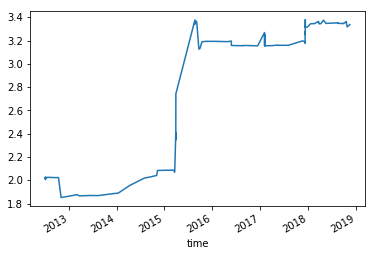

In [10]:
historical_scores['time'] =pandas.to_datetime(historical_scores.timestamp, format='%Y-%m-%dT%H:%M:%SZ',errors='ignore')
historical_scores = historical_scores.set_index('time')
historical_scores['weighted_sum'].plot()